# [Open in Google Colab](https://colab.research.google.com/github/Jechen00/yolov3-pytorch/blob/main/notebooks/yolov3_predictions.ipynb)

# Packages and Dependencies


In [1]:
import torch

from IPython.display import clear_output, display
import random
import sys, os
import yaml, pickle

# Importing torchmetrics (Not used here, but needed for imports)
try:
    import torchmetrics
except:
    print('\033[1m[ALERT]\033[0m torchmetrics not found. Installing with pip...')
    !pip install torchmetrics==1.7.2

# Check if running in Google Colab
try:
    import google.colab
    print('\033[1m[ALERT]\033[0m Running in Google Colab.')
    IN_COLAB = True
    REPO_PATH = './yolov3-pytorch'

except ImportError:
    print('\033[1m[ALERT]\033[0m Running in yolov3-pytorch repository.')
    IN_COLAB = False
    REPO_PATH = '..'

# Clone repo if it doesn't exist
if IN_COLAB and (not os.path.exists(REPO_PATH)):
    print('\033[1m[ALERT]\033[0m Repository not found. Cloning yolov3-pytorch from GitHub...')
    !git clone https://github.com/Jechen00/yolov3-pytorch.git

# Check if pretrained weights directory exist (Not needed)
# pretrained_weights_dir = os.path.join(REPO_PATH, 'pretrained_weights')
# if not os.path.exists(pretrained_weights_dir):
#     print('\033[1m[ALERT]\033[0m Repository does not contain pretrained_weights directory. Downloading from Google Drive...')
#     !gdown 11VTHYuuqGtnuMxAmqHpHeNVJOhOs_VWS -O ./yolov3-pytorch/pretrained_weights --folder

# Check if saved_models directory exists
saved_models_dir = os.path.join(REPO_PATH, 'saved_models')
if not os.path.exists(saved_models_dir):
    print('\033[1m[ALERT]\033[0m Repository does not contain saved_models directory. '
          'Downloading from Google Drive...')
    !gdown 1m2RO3Y1EV4YcEBcbotueOA2SEFbWUPSJ -O ./yolov3-pytorch/saved_models --folder

# Import repo modules
sys.path.append(os.path.abspath(REPO_PATH))
from src.models import builder, ema_model
from src.data_setup import voc_dataset, dataset_utils, transforms
from src.utils import plot

clear_output() # Clear the cluttered output after setup

# Load Saved Model

The model being loaded here was trained on Pascal VOC, and used **softmax** on class scores (since Pascal VOC only has one label per object).

In [2]:
save_path = os.path.join(REPO_PATH, 'saved_models/yolov3_voc/')

# -------------------------------
# Load Training Configurations
# -------------------------------
with open(save_path + 'training_config.yaml', 'r') as f:
    configs = yaml.safe_load(f)

base_model_cfgs = configs['base_model']
ema_cfgs = configs['ema']

# Change config and weight files to be relative to the notebook
for key in ['backbone_cfg', 'backbone_weights', 'neck_heads_cfg']:
    trimmed_file = base_model_cfgs[key].partition('/')[-1]
    base_model_cfgs[key] = os.path.join(REPO_PATH, trimmed_file)


# -------------------------------
# Load Saved Base and EMA Model
# -------------------------------
darknet53_backbone = builder.DarkNet53Backbone(cfg_file = base_model_cfgs['backbone_cfg'])
base_model = builder.YOLOv3(backbone = darknet53_backbone,
                            neck_heads_cfg = base_model_cfgs['neck_heads_cfg'])

ema = ema_model.EMA(base_model = base_model,
                    decay = ema_cfgs['decay'],
                    input_shape = tuple(base_model_cfgs['input_shape']))


# Note: Using EMA already initalizes all lazy layers in base_model
base_state_dict = torch.load(os.path.join(save_path, 'base_state_dict.pth'), map_location = 'cpu')
base_model.load_state_dict(base_state_dict)

ema_state_dict = torch.load(os.path.join(save_path, 'ema_state_dict.pth'), map_location = 'cpu')
ema.load_state_dict(ema_state_dict)


# -------------------------------
# Load Results
# -------------------------------
with open(os.path.join(save_path, 'training_results.pkl'), 'rb') as f:
    res = pickle.load(f)

# Plotting Results

obj_threshold: 0.01          nms_threshold: 0.5          map_thresholds: [0.5]          


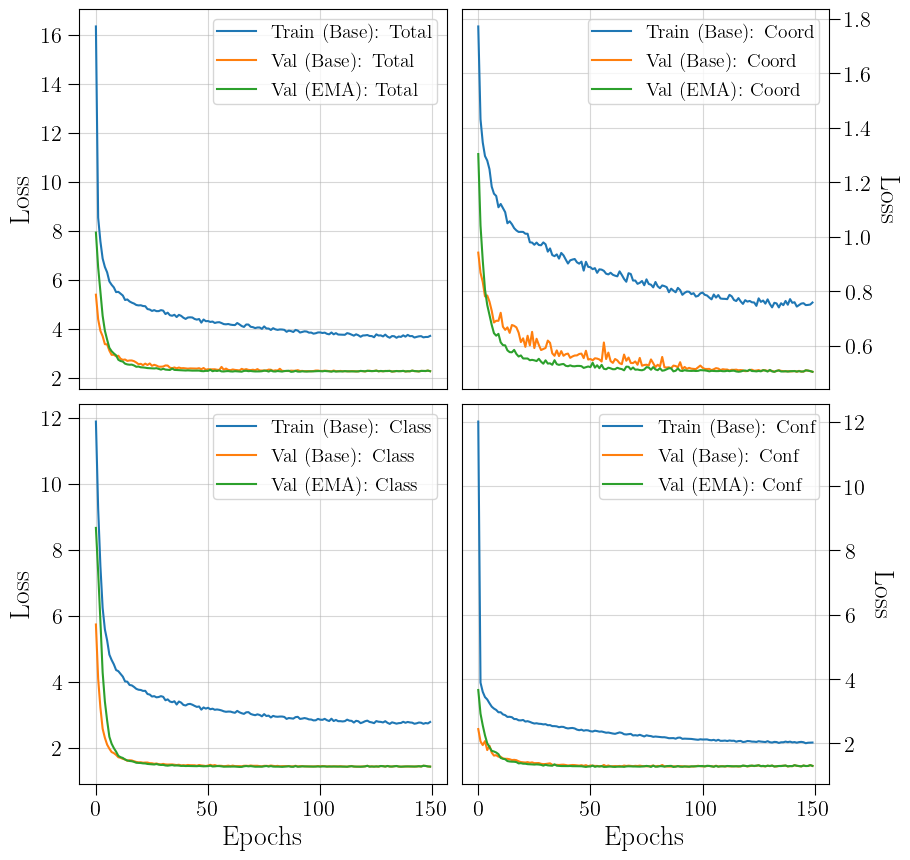

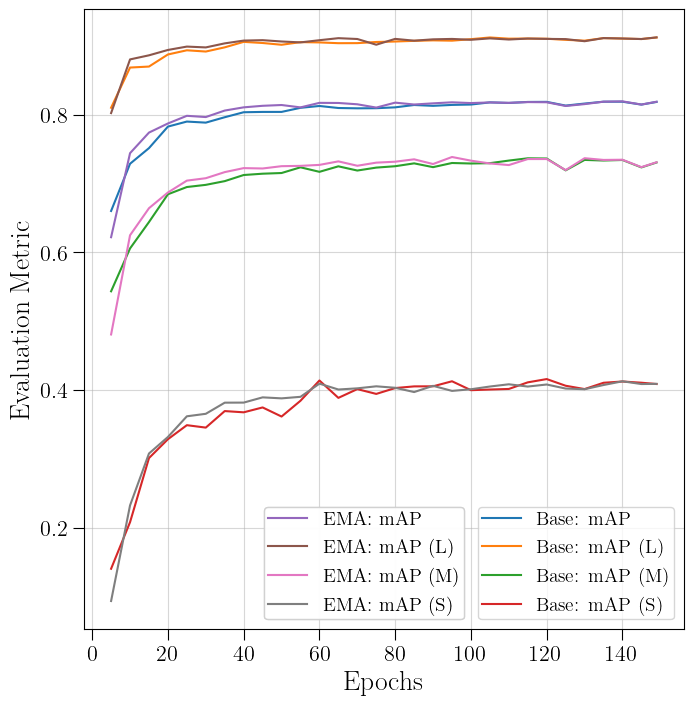

In [3]:
# Print the thresholds used during evaluation
threshold_str = ''
for key in ['obj_threshold', 'nms_threshold', 'map_thresholds']:
    threshold_str += f'{key}: {configs["train_eval"][key]}{" " * 10}'
print(threshold_str)

# Plot losses and eval metrics from training/evaluation
base_train_losses = res['base_train_losses']
base_val_losses = res['val_losses'].get('base')
ema_val_losses = res['val_losses'].get('ema')

base_eval_history = res['eval_histories'].get('base')
ema_eval_history = res['eval_histories'].get('ema')

map_keys = ['map', 'map_large', 'map_medium', 'map_small']

loss_fig = plot.plot_loss_results(base_train_losses = base_train_losses,
                                  base_val_losses = base_val_losses,
                                  ema_val_losses = ema_val_losses)
eval_fig = plot.plot_eval_results(base_eval_history = base_eval_history,
                                  ema_eval_history = ema_eval_history,
                                  eval_keys = map_keys)

display(loss_fig)
display(eval_fig)

# Predictions

In [4]:
# Get a dataset to get images from
ROOT = os.path.join(REPO_PATH, 'data/voc/')

scale_anchors, strides, _ = base_model.infer_scale_info(tuple(base_model_cfgs['input_shape']))

dataset = voc_dataset.VOCDataset(
    root = ROOT,
    scale_anchors = scale_anchors,
    strides = strides,
    split = 'val'
)

class_names, class_clrs = dataset_utils.load_classes(
    label_path = os.path.join(ROOT, 'voc.names'),
    return_idx_map = False,
    clr_shuffle_seed = 42
)

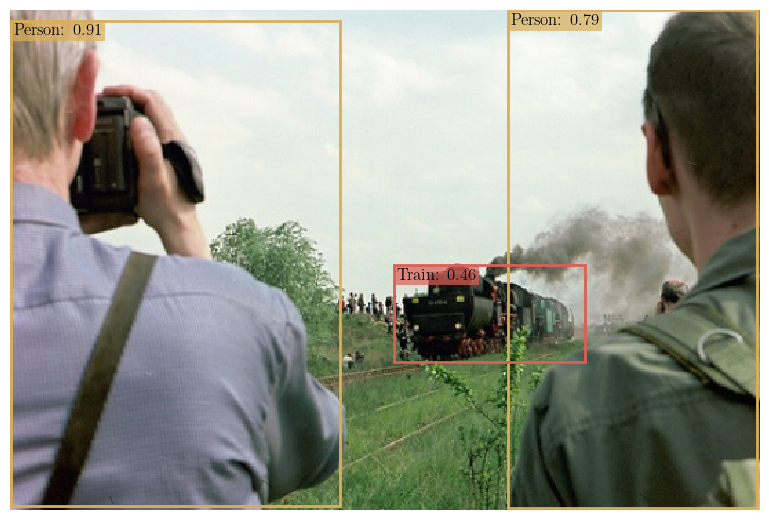

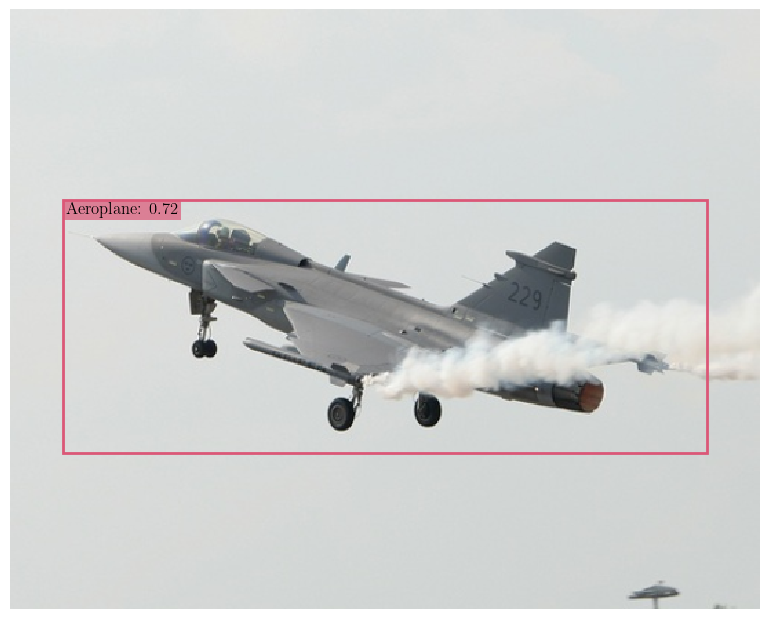

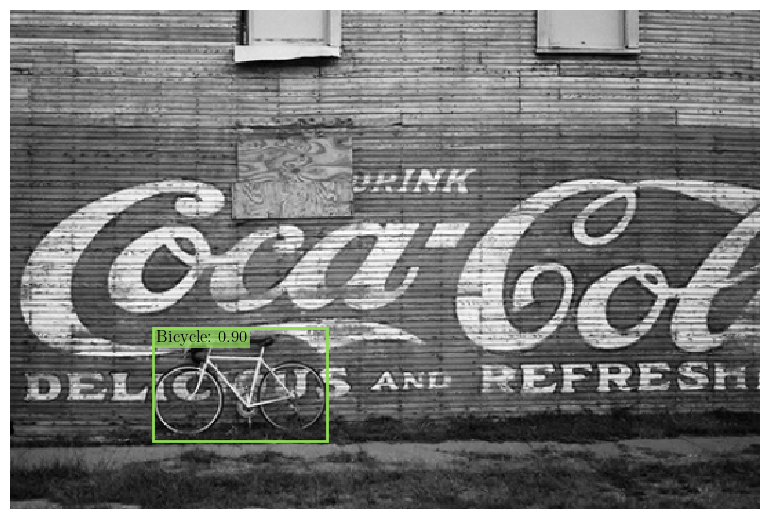

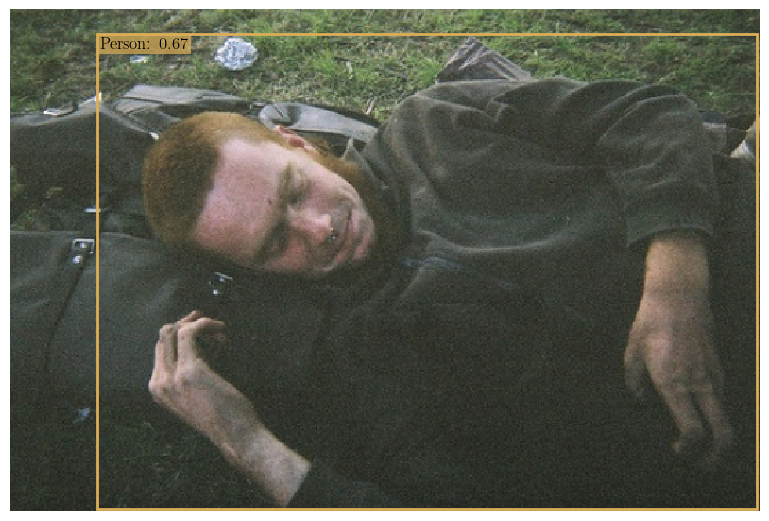

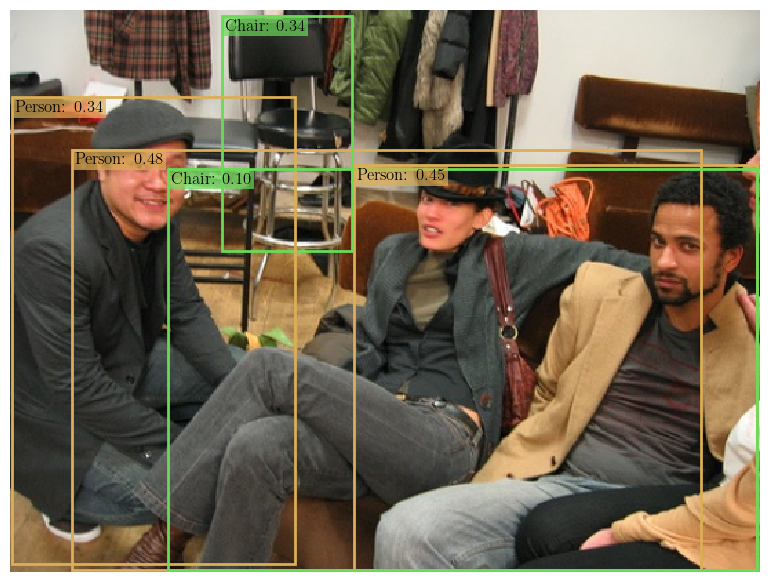

In [5]:
pred_model = ema.ema_model # Using EMA model to predict

SIZE = (544, 544) # Set size of the inputs
NUM_SAMPLES = 5

img_transforms = transforms.get_single_transforms(train = False, size = SIZE)
samp_idxs = random.sample(range(len(dataset)), NUM_SAMPLES)

for img_idx in samp_idxs:
    img = dataset.get_img(img_idx)

    fig = plot.draw_preds_yolov3(
        model = pred_model,
        img = img,
        img_transforms = img_transforms,
        scale_anchors = scale_anchors,
        strides = strides,
        class_names = class_names,
        class_clrs = class_clrs,
        obj_threshold = 0.2,
        nms_threshold = 0.5,
        softmax_probs = True, # Can swap with configs['loss_fn']['softmax_probs']
        rm_lb_pad = True,
        show_probs = True,
        figsize = (10, 10)
    )

    display(fig)